In [2]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.measure
import scipy.ndimage
from scipy.interpolate import interp2d

from src.datasets import BiosensorDataset, create_datasets
from src.test_models.test_parts import *
from src.train import train_model
from src.evaluate import evaluate
from src.utils import *

c:\Users\wittd\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
class UNet4(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, bilinear_upscaling=True):
        super(UNet4, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = SingleConv(n_channels, 64)
        self.down1 = DownSingle(64, 128)
        self.down2 = DownSingle(128, 256)
        self.down3 = DownSingle(256, 512)
        self.down4 = DownSingle(512, 512)
        self.up1 = UpSingle(1024, 256, bilinear)
        self.up2 = UpSingle(512, 128, bilinear)
        self.up3 = UpSingle(256, 64, bilinear)
        self.up4 = UpSingle(128, 32, bilinear)
        self.up5 = UpSingle(64, 16, bilinear)
        self.up6 = UpSingle(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)

        self.up_s1=Upscaling(64, 32, bilinear_upscaling)
        self.up_s2=Upscaling(32, 16, bilinear_upscaling)

    def forward(self, xs):
        x1 = self.inc(xs)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Upsample "negative" layers
        x0=self.up_s1(x1)
        x_1=self.up_s2(x0)
        
        x = self.up5(x, x0)
        x = self.up6(x, x_1)
        x = self.outc(x)
        return x

In [ ]:
class UNet8(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, bilinear_upscaling=True):
        super(UNet8, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = SingleConv(n_channels, 64)
        self.down1 = DownSingle(64, 128)
        self.down2 = DownSingle(128, 256)
        self.down3 = DownSingle(256, 512)
        self.down4 = DownSingle(512, 512)
        self.up1 = UpSingle(1024, 256, bilinear)
        self.up2 = UpSingle(512, 128, bilinear)
        self.up3 = UpSingle(256, 64, bilinear)
        self.up4 = UpSingle(128, 32, bilinear)
        self.up5 = UpSingle(64, 16, bilinear)
        self.up6 = UpSingle(32,8, bilinear)
        self.up7 = UpSingle(16,8, bilinear)
        self.outc = OutConv(8, n_classes)

        self.up_s1=Upscaling(64, 32, bilinear_upscaling)
        self.up_s2=Upscaling(32, 16, bilinear_upscaling)
        self.up_s3=Upscaling(16, 8, bilinear_upscaling)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        x0=self.up_s1(x1)
        x_1=self.up_s2(x0)
        x_2=self.up_s3(x_1)

        x = self.up5(x, x0)
        x = self.up6(x, x_1)
        x = self.up7(x, x_2)
        x = self.outc(x)
        return x

In [3]:
def getitem(path, files, index):
    data = np.load(path + files[index])
    bio = data['biosensor'].astype(np.float32)
    name = data['old_filename']

    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 1, 1)
    plt.imshow(bio[-1])
    plt.title(name)


In [4]:
data_path = 'C:/onlab_git/Onlab/data_with_centers/'
train_percent = 0.614
test_percent = 0.30


files = os.listdir(data_path)
train_size = int(train_percent * len(files))
val_size = len(files) - train_size
if test_percent>0:
    test_size = int(test_percent * len(files))
    val_size = val_size - test_size

print('Train size:', train_size)
print('Validation size:', val_size)
print('Test size:', test_size)

Train size: 100
Validation size: 15
Test size: 48


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)
np.random.seed(42)

data_path = 'C:/onlab_git/Onlab/data_with_centers/'
checkpoint_dir = 'test_saves'
train_percent = 0.614
test_percent = 0.30
batch_size = 4
bio_len = 8
mask_size = 80*4

train_dataset, val_dataset, test_dataset = create_datasets(data_path, train_percent, bool, test_percent=test_percent, 
                                biosensor_length=bio_len, mask_size=mask_size, augment=False, 
                                dilation=0, input_scaling=True, upscale_mode='nearest') # nearest bilinear bicubic

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model = UNet(n_channels=bio_len, n_classes=1) #UNet4 UNet8
# model = model.to(device)

Using device cuda


In [ ]:
def plot_loader_data(loader, title):
    for batch_idx, (data, labels) in enumerate(loader):
        # Move the data and labels to the CPU
        data = data.cpu().numpy()
        labels = labels.cpu().numpy()

        # Plot each image in the batch
        for i in range(len(data)):
            index = (batch_idx * len(data) + i + 1)

            plt.figure(figsize=(20, 10))

            # Plot the input image
            plt.subplot(1, 3, 1)
            plt.imshow(data[i][-1], cmap='gray')
            plt.title(f'{title} - Image {index} ')

            # Plot the label
            plt.subplot(1, 3, 2)
            plt.imshow(labels[i], cmap='gray')
            plt.title(f'{title} - Label {index}')

            plt.subplot(1, 3, 3)
            plt.imshow(data[i][-1], cmap='gray')
            plt.imshow(labels[i], cmap='Reds', alpha=0.25)

            plt.show()

plot_loader_data(test_loader, 'Test')

In [19]:
try:
    train_model(
        model,
        device,
        train_loader,
        val_loader,
        learning_rate=0.01,
        epochs=10,
        checkpoint_dir=checkpoint_dir,
        amp=True,
        wandb_logging=False
    )
except torch.cuda.OutOfMemoryError:
    torch.cuda.empty_cache()
    print('Detected OutOfMemoryError!')

Starting training:
        Epochs:          10
        Batch size:      4
        Learning rate:   0.01
        Training size:   80
        Validation size: 35
        Device:          cuda
        Mixed Precision: True
        Dilatation:      0
    


Epoch 1/10: 100%|██████████| 80/80 [00:13<00:00,  6.08img/s, loss (batch)=0.807]


Validation Dice score: 0.002604305511340499, Detection rate: 0.005486466715435259
Checkpoint 1 saved!


Epoch 2/10: 100%|██████████| 80/80 [00:13<00:00,  5.90img/s, loss (batch)=0.978]


Validation Dice score: 0.21715934574604034, Detection rate: 0.2607900512070227
Checkpoint 2 saved!


Epoch 3/10: 100%|██████████| 80/80 [00:13<00:00,  6.02img/s, loss (batch)=0.747]


Validation Dice score: 0.3683970868587494, Detection rate: 0.633138258961229
Checkpoint 3 saved!


Epoch 4/10: 100%|██████████| 80/80 [00:13<00:00,  5.85img/s, loss (batch)=0.784]


Validation Dice score: 0.35669973492622375, Detection rate: 0.7136064374542794
Checkpoint 4 saved!


Epoch 5/10: 100%|██████████| 80/80 [00:13<00:00,  5.99img/s, loss (batch)=0.675]


Validation Dice score: 0.3310006260871887, Detection rate: 0.7388441843452817
Checkpoint 5 saved!


Epoch 6/10: 100%|██████████| 80/80 [00:13<00:00,  5.89img/s, loss (batch)=0.896]


Validation Dice score: 0.40452465415000916, Detection rate: 0.7553035844915874
Checkpoint 6 saved!


Epoch 7/10: 100%|██████████| 80/80 [00:13<00:00,  6.02img/s, loss (batch)=0.672]


Validation Dice score: 0.4081939160823822, Detection rate: 0.7286027798098025
Checkpoint 7 saved!


Epoch 8/10: 100%|██████████| 80/80 [00:13<00:00,  5.96img/s, loss (batch)=0.78] 


Validation Dice score: 0.38368427753448486, Detection rate: 0.7750548646671543
Checkpoint 8 saved!


Epoch 9/10: 100%|██████████| 80/80 [00:13<00:00,  5.84img/s, loss (batch)=0.782]


Validation Dice score: 0.4055405855178833, Detection rate: 0.8057790782735919
Checkpoint 9 saved!


Epoch 10/10: 100%|██████████| 80/80 [00:13<00:00,  6.10img/s, loss (batch)=0.696]

Validation Dice score: 0.4229012131690979, Detection rate: 0.8094367227505487
Checkpoint 10 saved!


In [20]:
# from torchsummary import summary
# Print the model summary
# summary(model, input_size=(bio_len, mask_size, mask_size))

# Load the checkpoint
checkpoint = torch.load("test_saves/checkpoint_epoch10.pth")
# Get the learning rate and remove it from the checkpoint
lr = checkpoint.pop('learning_rate')
# Load the state dictionary into the model
model.load_state_dict(checkpoint)
# Move the model to the device
model = model.to(device)

In [21]:
val_dice_score, val_detection_rate = evaluate(model, val_loader, device)
dice_score, detection_rate = evaluate(model, test_loader, device)
print(f'Validation dice score: {val_dice_score}, Detection rate: {val_detection_rate}')
print(f'Validation dice score: {dice_score}, Detection rate: {detection_rate}')

Validation dice score: 0.4229012131690979, Detection rate: 0.8094367227505487
Validation dice score: 0.39796900749206543, Detection rate: 0.7714558928998326


In [15]:
# Saving the best model for production
# model = UNet(n_channels=8, n_classes=1)
# checkpoint = torch.load("checkpoints/checkpoint_8_4_85.pth")
# lr = checkpoint.pop('learning_rate')
# model.load_state_dict(checkpoint)

# torch.jit.script(model).save('saved_models/unet_len8.pth')

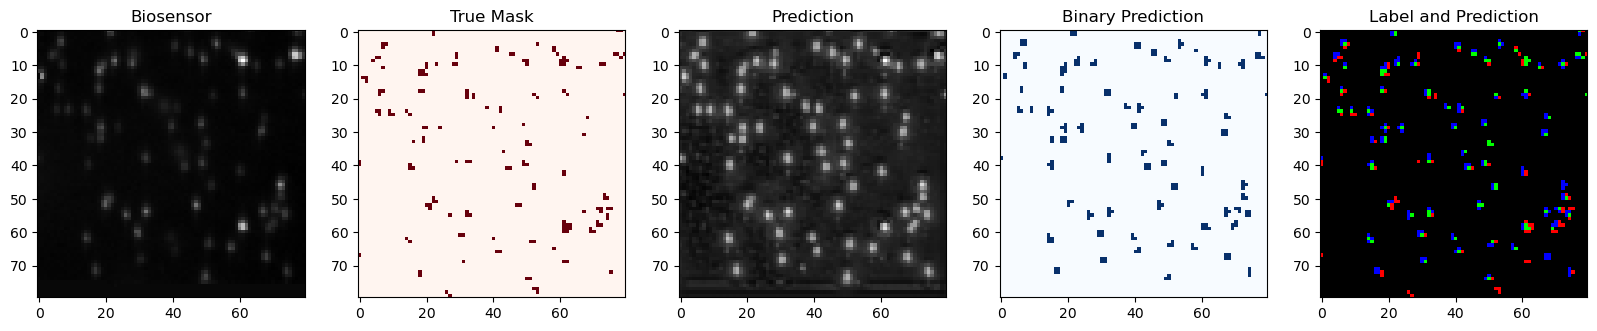

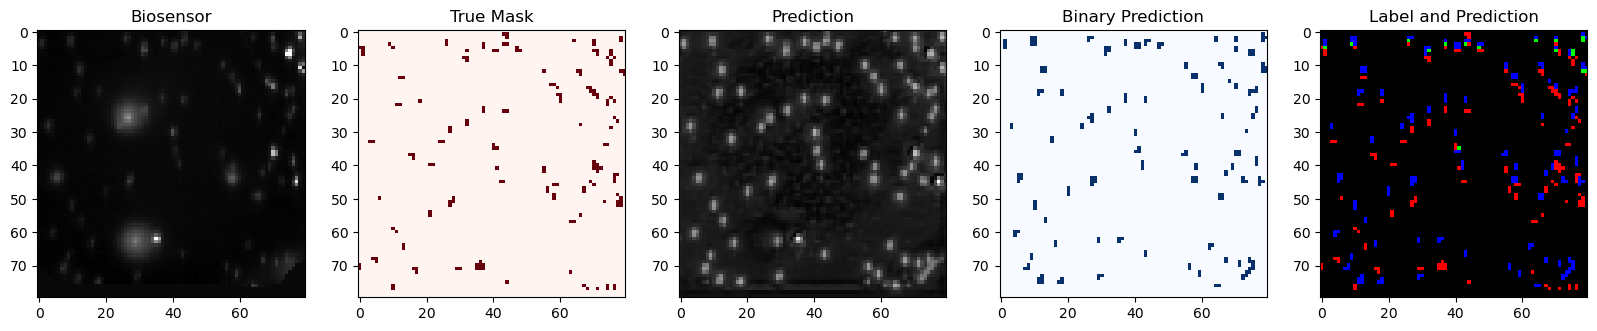

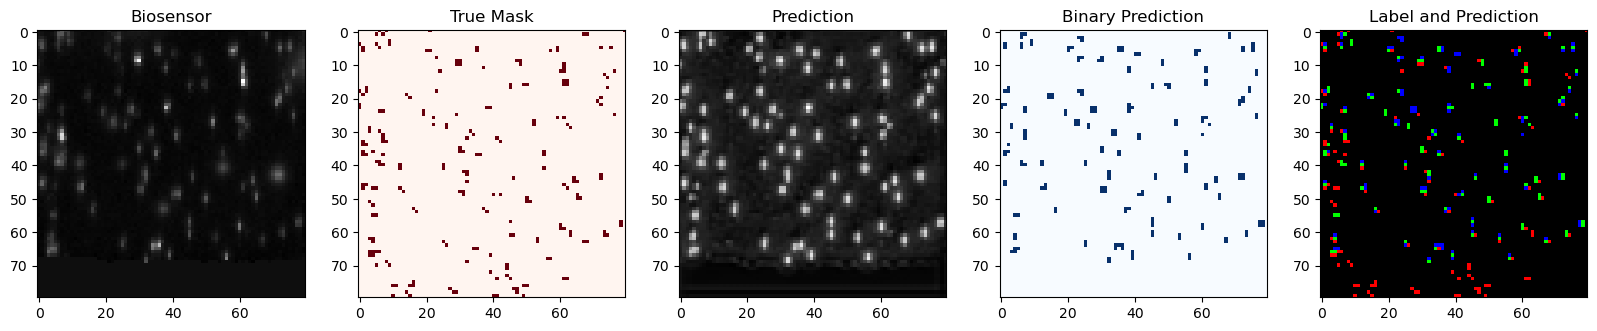

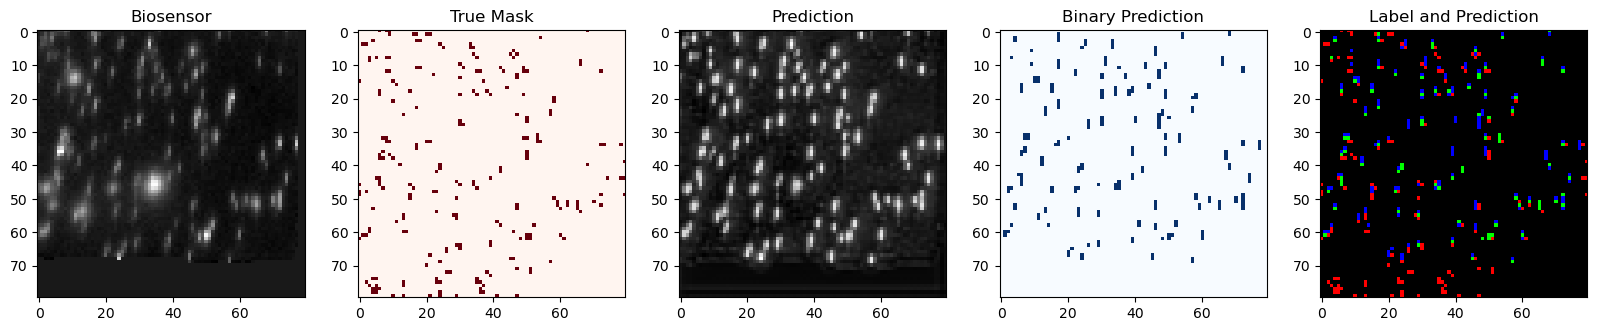

In [39]:
# Load a batch of data and labels
loader_iter = iter(test_loader)
data, labels = next(loader_iter)
data, labels = next(loader_iter)
data, labels = next(loader_iter)

# Move the data and labels to the device
data = data.to(device)
labels = labels.to(device)

# Get the predictions
predictions = model(data)

binary_predictions = (torch.nn.functional.sigmoid(predictions) > 0.5)
binary_predictions = binary_predictions.cpu().detach().numpy()

labels = labels.cpu().numpy()
predictions = predictions.cpu().detach().numpy()

# Plot the data, the labels, and the predictions
for i in range(len(data)):
    label = np.squeeze(labels[i])
    binary_prediction = np.squeeze(binary_predictions[i])

    plt.figure(figsize=(20, 50))
    
    plt.subplot(1, 5, 1)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.title('Biosensor')
    
    plt.subplot(1, 5, 2)
    plt.imshow(label, cmap='Reds')
    plt.title('True Mask')
    
    plt.subplot(1, 5, 3)
    plt.imshow(np.squeeze(predictions[i]), cmap='gray')
    plt.title('Prediction')

    plt.subplot(1, 5, 4)
    plt.imshow(binary_prediction, cmap='Blues')
    plt.title('Binary Prediction')

    combined_img = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.float32)
    # Assign colors
    combined_img[(label == 1) & (binary_prediction == 0)] = [1, 0, 0]  # Red for label only
    combined_img[(label == 0) & (binary_prediction == 1)] = [0, 0, 1]  # Blue for prediction only
    combined_img[(label == 1) & (binary_prediction == 1)] = [0, 1, 0]  # Green for overlap

    plt.subplot(1, 5, 5)
    plt.imshow(combined_img)
    plt.title('Label and Prediction')
    
    plt.show()